<a href="https://colab.research.google.com/github/gauriklad/dagster-ML-pipeline/blob/main/Dagster_ML_Reproducible_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dagster dagster-webserver pyarrow

In [24]:
%%writefile pipeline.py
from dagster import fs_io_manager
import pandas as pd
import matplotlib.pyplot as plt
from dagster import op, job, Definitions
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import os
import seaborn as sns

@op
def load_data():

    df = pd.read_csv("/content/taxi_trips_2024.csv")
    df.columns = [c.replace(" ", "_").lower() for c in df.columns]
    df = df.dropna(subset=['trip_seconds', 'trip_miles', 'trip_total'])
    return df

@op
def generate_eda(load_data):

    df = load_data
    df_clean = df[(df['trip_total'] > 0) & (df['trip_total'] < 150)]
    df_clean = df_clean[(df['trip_miles'] > 0) & (df['trip_miles'] < 50)]
    if not os.path.exists("eda_plots"):
        os.makedirs("eda_plots")

    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    numeric_cols = ['trip_seconds', 'trip_miles', 'fare', 'tips', 'trip_total']
    numeric_df = df_clean[numeric_cols].dropna()

    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Matrix")
    plt.tight_layout()
    plt.savefig("eda_plots/correlation_heatmap.png")
    plt.close()

    # Distribution Plot
    plt.figure(figsize=(10, 6))
    sns.histplot(df_clean['trip_total'], bins=50, kde=True)
    plt.title("Distribution of Trip Fares (Filtered < $150)")
    plt.xlabel("Total Fare ($)")
    plt.tight_layout()
    plt.savefig("eda_plots/trip_total_dist.png")
    plt.close()

    print("EDA plots saved in eda_plots folder")

@op
def preprocess_data(df):

    X = df[['trip_seconds', 'trip_miles']]
    y = df['trip_total']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

@op
def train_decision_tree(data):

    model = DecisionTreeRegressor(max_depth=5)
    model.fit(data["X_train"], data["y_train"])
    preds = model.predict(data["X_test"])
    mae = mean_absolute_error(data["y_test"], preds)
    return mae

@op
def train_random_forest(data):

    model = RandomForestRegressor(n_estimators=50, max_depth=10)
    model.fit(data["X_train"], data["y_train"])
    preds = model.predict(data["X_test"])
    mae = mean_absolute_error(data["y_test"], preds)
    return mae

@op
def train_linear_regression(data):

    model = LinearRegression()
    model.fit(data["X_train"], data["y_train"])
    preds = model.predict(data["X_test"])
    mae = mean_absolute_error(data["y_test"], preds)
    return mae

@op
def compare_models(dt_mae, rf_mae, lr_mae):

    report = "\nModel Performance:\n"
    report += f"Decision Tree MAE: {dt_mae}\n"
    report += f"Random Forest MAE: {rf_mae}\n"
    report += f"Linear Regression MAE: {lr_mae}\n"
    best = min(dt_mae, rf_mae, lr_mae)
    report += f"\nBest Model MAE: {best}\n"

    print(report)
    with open("model_report.txt", "w") as f:
        f.write(report)

    return best

@job
def taxi_pipeline_job():

    df = load_data()
    generate_eda(df)
    data = preprocess_data(df)
    dt = train_decision_tree(data)
    rf = train_random_forest(data)
    lr = train_linear_regression(data)
    compare_models(dt, rf, lr)

defs = Definitions(
    jobs=[taxi_pipeline_job],
    resources={
        "io_manager": fs_io_manager
    }
)

Overwriting pipeline.py


In [9]:
import time

!pkill dagster
!pkill dagster-webserver
print("Stopped old server. Starting new server")
get_ipython().system_raw('dagster dev -f pipeline.py -h 0.0.0.0 -p 3000 &')
time.sleep(10)
print("Server started")

Stopped old server. Starting new server...
Server started!


In [21]:
from google.colab import output
print("Click the link below to Dagster:")
output.serve_kernel_port_as_window(3000)

Click the link below to Dagster:
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

MODEL COMPARISON RESULTS


EDA VISUALIZATIONS

Displaying: trip_total_dist.png


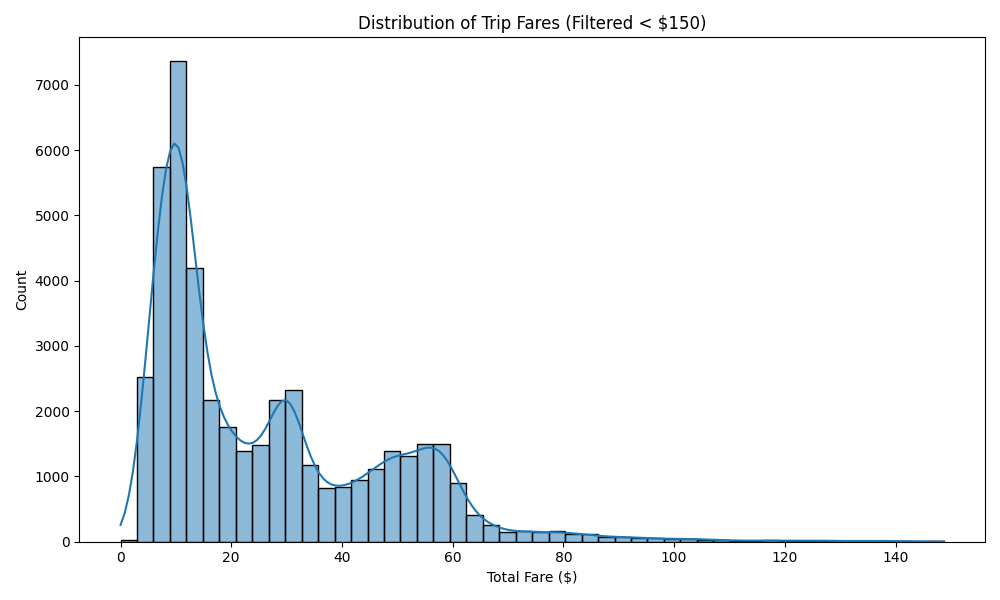

Displaying: correlation_heatmap.png


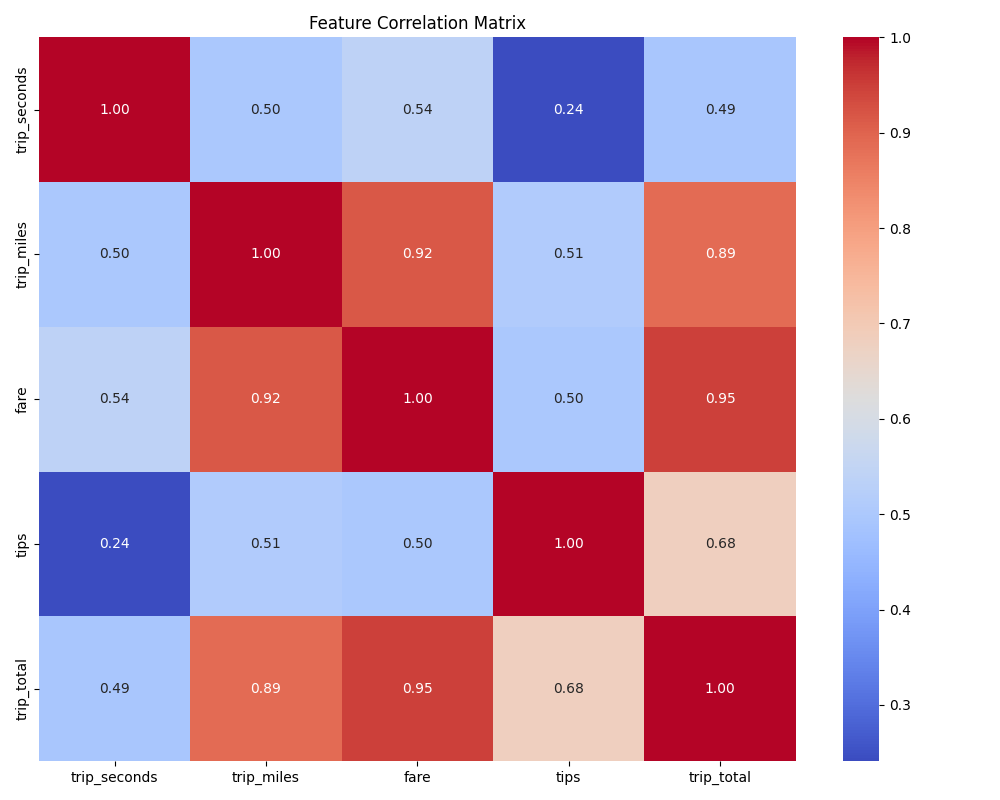

In [22]:
from IPython.display import Image, display
import os

print("MODEL COMPARISON RESULTS\n")
print("\nEDA VISUALIZATIONS\n")

eda_path = "eda_plots"

if os.path.exists(eda_path):

    images = [img for img in os.listdir(eda_path) if img.endswith(".png")]

    if len(images) == 0:
        print("No EDA images found.")
    else:
        for img_file in images:
            print(f"Displaying: {img_file}")
            display(Image(filename=os.path.join(eda_path, img_file)))

else:
    print("EDA folder not found. Please run pipeline first.")
